In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from combat.pycombat import pycombat
from sklearn.model_selection import GroupShuffleSplit
import joblib
import warnings
import shap
from sklearn.metrics import f1_score
import re
from lime.lime_tabular import LimeTabularExplainer
import seaborn as sns
shap.initjs()

In [2]:
os.chdir("../../Dataset/Merged")

In [3]:
dataset = pd.read_csv('MergedDatasetZeroes.csv', index_col=0)

sampleID = dataset['SampleID']
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
indicator = dataset['Label']
dataset = dataset.drop(columns=['SampleID', 'Label'])

dataset = pycombat(dataset.transpose(), datasetID).transpose()

dataset.insert(0, 'SampleID', sampleID)
dataset.insert(1, 'Label', indicator)

def getPatientID(sampleID):
    return sampleID.split('-')[0] + '-' + sampleID.split('-')[1].split('_', 1)[1]

dataset.insert(1, 'PatientID', dataset['SampleID'].apply(getPatientID))
gruppi = dataset.groupby('PatientID')

def sanity_check(gruppi):
    for group_name, group_data in gruppi:
        if 'Control' in group_data['SampleID'].iloc[0]:
            for e in group_data['SampleID']:
                if not 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break
        else:
            for e in group_data['SampleID']:
                if 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break

sanity_check(gruppi)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state = 42)
split = splitter.split(dataset, groups=dataset['PatientID'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
test = dataset.iloc[test_inds].sample(frac=1, random_state=42)

print("Dataset di train:")
print(train.shape)
print("I malati sono: ", sum(train['Label'] == 1))
print("I sani sono: ", sum(train['Label'] == 0))

print("\nDataset di test:")
print(test.shape)
print("I malati sono: ", sum(test['Label'] == 1))
print("I sani sono: ", sum(test['Label'] == 0))

y_train = train['Label']
x_train = train.drop(columns=['SampleID', 'Label', 'PatientID'])

y_test = test['Label']
x_test = test.drop(columns=['SampleID', 'Label', 'PatientID'])

Found 7 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\samue\AppData\Roaming\Python\Python311\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data
Dataset di train:
(1593, 12094)
I malati sono:  695
I sani sono:  898

Dataset di test:
(520, 12094)
I malati sono:  245
I sani sono:  275


Calcolo explanation

In [4]:
ensemble = joblib.load('../../Modelli/DatasetZeroes/ensembleSoft.pkl')
limeexplanation = joblib.load('../../ShapValues/DatasetZeroes/ensemble_lime.pkl')

In [ ]:
explainer = LimeTabularExplainer(training_data=np.array(x_train),feature_names=x_train.columns, class_names=['noMS', 'MS'], mode='classification')
warnings.filterwarnings('ignore', message="X does not have valid feature names")

explanations = []

for i in range(x_test.shape[0]):
    print(i)
    instance = x_test.iloc[i].to_numpy().reshape(1, -1)
    exp = explainer.explain_instance(data_row=instance.flatten(), predict_fn=ensemble.predict_proba)
    explanations.append(exp)

joblib.dump(explanations, '../../ShapValues/DatasetZeroes/ensemble_lime.pkl')                                                                                                             

In [5]:
def createMatrix(limeexplanation):
    arr = []
    dict = {}
    regex_pattern = r'\b[A-Za-z_][A-Za-z0-9_-]*\b'

    for feature in x_train.columns:
        dict[feature] = 0

    for exp in limeexplanation:
        for feature, val in exp.as_list():
            match = re.search(regex_pattern, feature)

            if match[0] not in x_train.columns:
                print(feature)
                break

            dict[match[0]] = float(val)
            
        arr.append(list(dict.values()))
            
        dict={}
        for feature in x_train.columns:
            dict[feature] = 0
            
    return arr

expl = createMatrix(limeexplanation)

In [6]:
joblib.dump(expl, '../../ShapValues/DatasetZeroes/ensemble_expl.pkl')

['../../ShapValues/DatasetZeroes/ensemble_expl.pkl']

In [4]:
expl = joblib.load('../../ShapValues/DatasetZeroes/ensemble_expl.pkl')
expl_summary = np.abs(expl).mean(0)

In [8]:
joblib.dump(expl_summary, '../../ShapValues/DatasetZeroes/ensemble_summary.pkl')

['../../ShapValues/DatasetZeroes/ensemble_summary.pkl']

In [5]:
expl_summary = joblib.load('../../ShapValues/DatasetZeroes/ensemble_summary.pkl')
ensemble_ablation = joblib.load("../../ShapValues/DatasetZeroes/ensembleSoft_ablationScores.pkl")
expl_dictSummary = dict(zip(x_train.columns, expl_summary))

In [6]:
expl_sorted = dict(sorted(expl_dictSummary.items(), key=lambda item: item[1], reverse=True))
print(list(expl_sorted.values())[:50])
print(list(expl_sorted.keys())[:50])

ensemble_sorted_scores = dict(sorted(ensemble_ablation.items(), key=lambda item: item[1], reverse=True))
ensemble_bestFeatures = {key: value for key, value in ensemble_sorted_scores.items() if value > 1.0}
ensemble_worstFeatures = {key: value for key, value in ensemble_sorted_scores.items() if value < 1.0}
print("Le feature migliori sono: ", len(ensemble_bestFeatures), ensemble_bestFeatures)
print("Le feature rumorose sono: ", len(ensemble_worstFeatures), ensemble_worstFeatures)

print(list(ensemble_bestFeatures.keys()))
print(list(ensemble_worstFeatures.keys()))

[0.08909613239647805, 0.02927119283716082, 0.011444993512170666, 0.009551664388068608, 0.009535529535301205, 0.007011916140200314, 0.00641943424945542, 0.006187598693417952, 0.005919120979058789, 0.00552560255134773, 0.00546989595479282, 0.00263119146595462, 0.001737684739657046, 0.0014741479231515995, 0.0011098021997014247, 0.0010799109127921326, 0.0007517183271330257, 0.0005758235480262709, 0.00040621967570442084, 0.00029026553191564147, 0.0002638946866021863, 0.00026088872055552993, 0.00024146298050777853, 0.00020728149880007034, 0.00020269451775998558, 0.00015491581319826336, 0.0001287084927467553, 0.00012592219162860677, 0.00011465140984774027, 0.00010788631693517937, 9.818639434362375e-05, 9.811680351754068e-05, 8.253662859957795e-05, 7.775338710948123e-05, 7.740908299156612e-05, 7.737183750279853e-05, 7.101730756593397e-05, 7.066787537046927e-05, 6.895662927005045e-05, 6.837077931541897e-05, 6.707632962858203e-05, 6.368472383616823e-05, 6.367623290958107e-05, 6.276739520412724e-

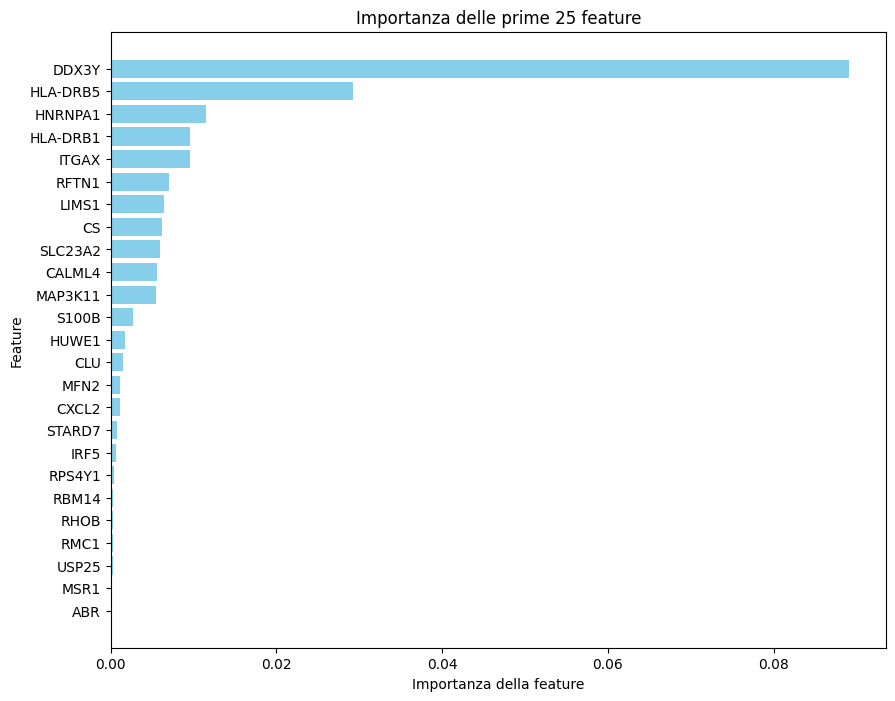

In [7]:
max_display = 25
top_features = list(expl_sorted.keys())[:max_display]
top_importances = list(expl_sorted.values())[:max_display]

# Crea il grafico a barre
plt.figure(figsize=(10, 8))
plt.barh(top_features[::-1], top_importances[::-1], color='skyblue')
plt.xlabel('Importanza della feature')
plt.ylabel('Feature')
plt.title('Importanza delle prime 25 feature')
plt.show()

In [10]:
print(list(expl_sorted.values())[:100])

[0.08909613239647805, 0.02927119283716082, 0.011444993512170666, 0.009551664388068608, 0.009535529535301205, 0.007011916140200314, 0.00641943424945542, 0.006187598693417952, 0.005919120979058789, 0.00552560255134773, 0.00546989595479282, 0.00263119146595462, 0.001737684739657046, 0.0014741479231515995, 0.0011098021997014247, 0.0010799109127921326, 0.0007517183271330257, 0.0005758235480262709, 0.00040621967570442084, 0.00029026553191564147, 0.0002638946866021863, 0.00026088872055552993, 0.00024146298050777853, 0.00020728149880007034, 0.00020269451775998558, 0.00015491581319826336, 0.0001287084927467553, 0.00012592219162860677, 0.00011465140984774027, 0.00010788631693517937, 9.818639434362375e-05, 9.811680351754068e-05, 8.253662859957795e-05, 7.775338710948123e-05, 7.740908299156612e-05, 7.737183750279853e-05, 7.101730756593397e-05, 7.066787537046927e-05, 6.895662927005045e-05, 6.837077931541897e-05, 6.707632962858203e-05, 6.368472383616823e-05, 6.367623290958107e-05, 6.276739520412724e-

Feature ritenute importanti sia dall'ablation che per importance

In [8]:
print([feature for feature in list(ensemble_bestFeatures.keys()) if feature in list(expl_sorted.keys())[:100]])

['DDX17', 'HLA-DRB1', 'HLA-DRB5']


Matrice di correlazione per i migliori 100 shap-importance

In [11]:
ensembleCorr = pd.DataFrame(expl, columns=x_train.columns)[list(expl_sorted.keys())[:100]].corr()
print(ensembleCorr)

           DDX3Y     USP9Y      GIT2    PABPC1    RPS4Y1     C4BPA  HLA-DRB5  \
DDX3Y   1.000000  0.429587  0.410601  0.451983  0.305990  0.489862  0.187996   
USP9Y   0.429587  1.000000  0.093661  0.328794 -0.349307  0.200254 -0.001365   
GIT2    0.410601  0.093661  1.000000  0.222900  0.218023  0.369419  0.193969   
PABPC1  0.451983  0.328794  0.222900  1.000000  0.180031  0.194691  0.042157   
RPS4Y1  0.305990 -0.349307  0.218023  0.180031  1.000000  0.158298  0.103332   
...          ...       ...       ...       ...       ...       ...       ...   
RSL1D1  0.008566 -0.023171  0.009637 -0.001577  0.002647  0.068592  0.001615   
TRMU   -0.067406 -0.046796  0.021501 -0.065550  0.018927 -0.018496 -0.093937   
ERGIC3 -0.005216 -0.024567  0.009716 -0.032415  0.071211 -0.035194 -0.088549   
MT1X   -0.009666  0.078153  0.038842  0.008025 -0.043329  0.013164 -0.008217   
AZU1    0.047711  0.034357  0.022007 -0.012658 -0.015587 -0.085535  0.003344   

        HLA-DRB1      UBR4    CRIPTO  .

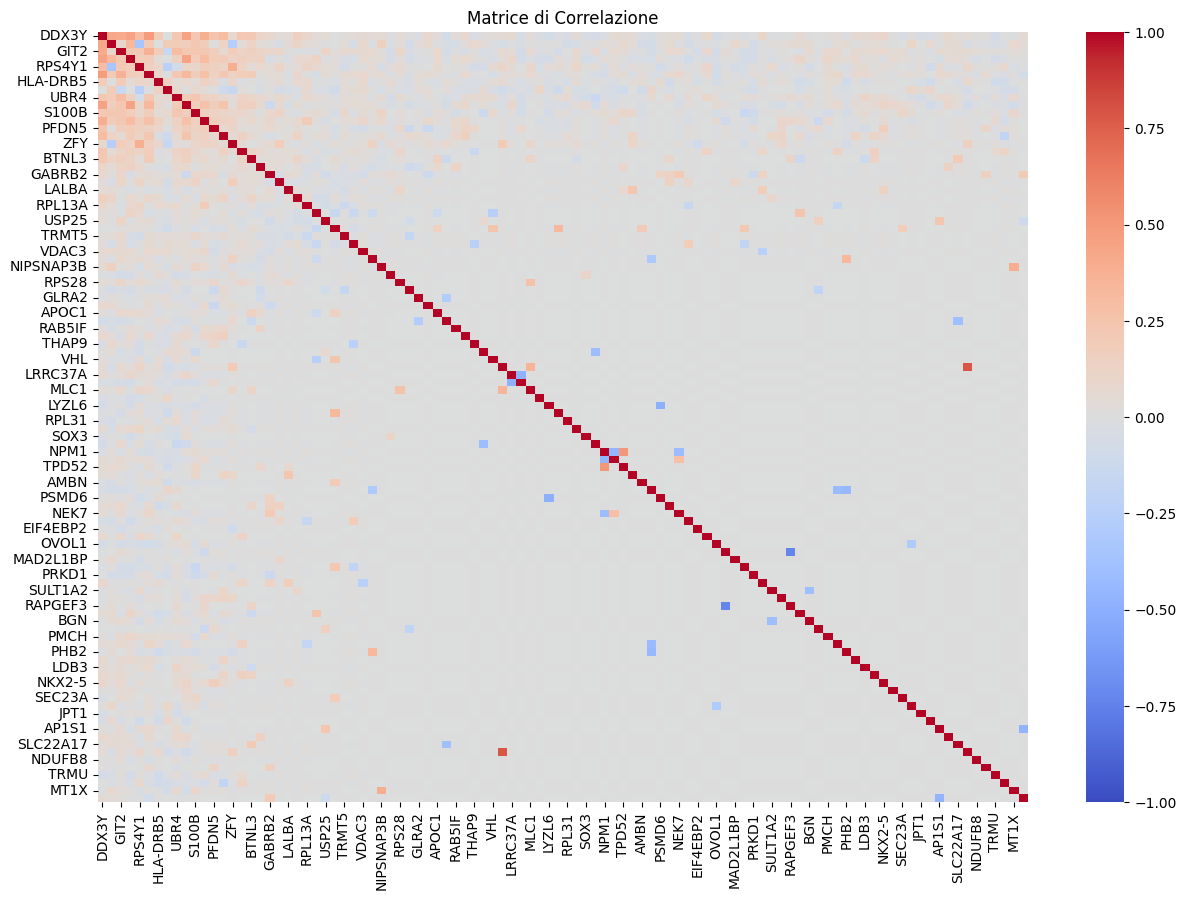

In [12]:
plt.figure(figsize=(15,10))
sns.heatmap(ensembleCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione')
plt.show()

In [16]:
ensemble_correlated_pairs = np.where(np.abs(ensembleCorr) >= 0.45)

# Print the correlated pairs
for i, j in zip(ensemble_correlated_pairs[0], ensemble_correlated_pairs[1]):
    if i != j:
        print(f"{ensembleCorr.index[i]} - {ensembleCorr.columns[j]}: {ensembleCorr.iloc[i, j]}")

DDX3Y - PABPC1: 0.45198307742479754
DDX3Y - C4BPA: 0.4898620462271476
DDX3Y - CRIPTO: 0.45129057559452074
PABPC1 - DDX3Y: 0.45198307742479754
PABPC1 - CRIPTO: 0.45130253825404704
C4BPA - DDX3Y: 0.4898620462271476
CRIPTO - DDX3Y: 0.45129057559452074
CRIPTO - PABPC1: 0.45130253825404704
STARD7 - SRR: 0.7830905339935144
LRRC37A - RPS10: -0.4903723921761564
RPS10 - LRRC37A: -0.4903723921761564
LYZL6 - PSMD6: -0.500023385255267
NPM1 - GAPDH: -0.46199830929750224
NPM1 - TPD52: 0.5129051193995813
GAPDH - NPM1: -0.46199830929750224
TPD52 - NPM1: 0.5129051193995813
PSMD6 - LYZL6: -0.500023385255267
PPIA - RAPGEF3: -0.7333315185804182
RAPGEF3 - PPIA: -0.7333315185804182
AP1S1 - AZU1: -0.47491857155145323
SRR - STARD7: 0.7830905339935144
AZU1 - AP1S1: -0.47491857155145323


Matrice di correlazione per i migliori data dall'intersezione tra abalation e shap

{'HLA-DRB5', 'HLA-DRB1', 'DDX17'}
          HLA-DRB5  HLA-DRB1     DDX17
HLA-DRB5  1.000000  0.389685  0.050954
HLA-DRB1  0.389685  1.000000 -0.042615
DDX17     0.050954 -0.042615  1.000000


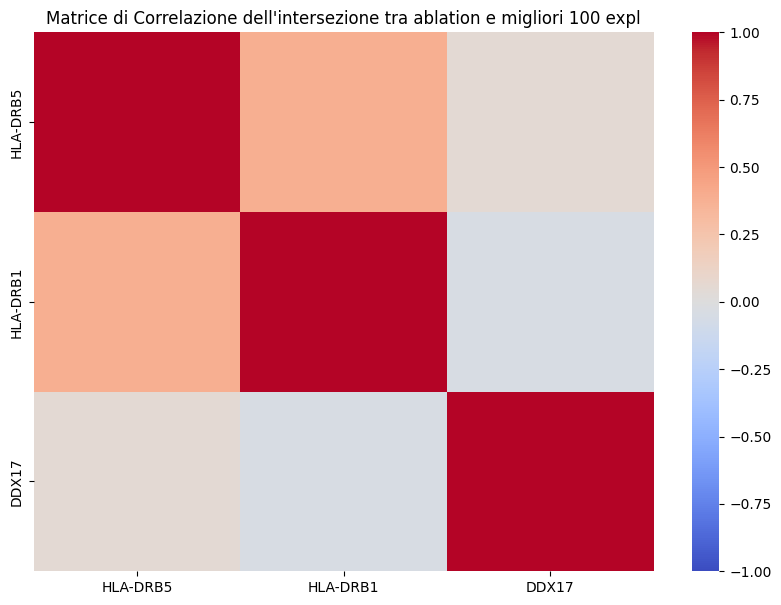

In [12]:
intersect = set(list(ensemble_bestFeatures.keys())).intersection(set(list(expl_sorted.keys())[:100]))

print(intersect)

intersectCorr = pd.DataFrame(expl, columns=x_train.columns)[list(intersect)].corr()
print(intersectCorr)

plt.figure(figsize=(10,7))
sns.heatmap(intersectCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione dell\'intersezione tra ablation e migliori 100 expl')
plt.show()

In [13]:
intersect_correlated_pairs = np.where(np.abs(intersectCorr) >= 0.375)

# Print the correlated pairs
for i, j in zip(intersect_correlated_pairs[0], intersect_correlated_pairs[1]):
    if i != j:
        print(f"{intersectCorr.index[i]} - {intersectCorr.columns[j]}: {intersectCorr.iloc[i, j]}")

HLA-DRB5 - HLA-DRB1: 0.38968453500387806
HLA-DRB1 - HLA-DRB5: 0.38968453500387806


In [11]:
ensemble_featureSelected = joblib.load('../../ShapValues/DatasetZeroes/ensembleSoft_featureSelection.pkl')
ensemble_sortedFeature = dict(sorted(ensemble_featureSelected.items(), key=lambda x: x[1], reverse=True))

Score	numFeature	feature
0.9620253164556962	368	 ('DDX3Y', 'HLA-DRB5', 'HNRNPA1', 'HLA-DRB1', 'ITGAX', 'RFTN1', 'LIMS1', 'CS', 'SLC23A2', 'CALML4', 'MAP3K11', 'S100B', 'HUWE1', 'CLU', 'MFN2', 'CXCL2', 'STARD7', 'IRF5', 'RPS4Y1', 'RBM14', 'RHOB', 'RMC1', 'USP25', 'MSR1', 'ABR', 'SASH3', 'DDX17', 'ARHGEF12', 'PKN2', 'TPM1', 'FRG1', 'ZBTB48', 'GALT', 'FBLN2', 'TNRC6B', 'BLCAP', 'RPL23A', 'ZNF611', 'ZBTB7A', 'MLLT10', 'OXCT1', 'TAL1', 'SAMM50', 'MOXD1', 'NR6A1', 'YWHAH-AS1', 'PDK3', 'RNF130', 'ZNF124', 'DNAL4', 'UBE2C', 'CSDE1', 'KCNJ2', 'IGF1R', 'HSD17B4', 'OGFRL1', 'LAD1', 'AKTIP', 'GCLC', 'ZNF10', 'PRPF19', 'HLA-DPA1', 'ARMH3', 'CLEC4E', 'ANKS1A', 'SMR3A', 'CLCF1', 'CASQ1', 'GPN1', 'YPEL1', 'JAG2', 'MON2', 'ZNF706', 'IL1RL2', 'ZNF767P', 'CD79A', 'SSH1', 'LPXN', 'DYRK3', 'PDSS2', 'TMEM127', 'ZNF133', 'GPR63', 'TCEAL1', 'ZNF219', 'RPS12', 'ERO1A', 'ARHGEF15', 'GNB1', 'PSTPIP2', 'PKD2L2', 'PANK3', 'RALA', 'HMGB2', 'SLC6A2', 'FMO3', 'RASSF1', 'DDX31', 'KANK1', 'ORC1', 'CNIH3', 'ING2', 'EDEM

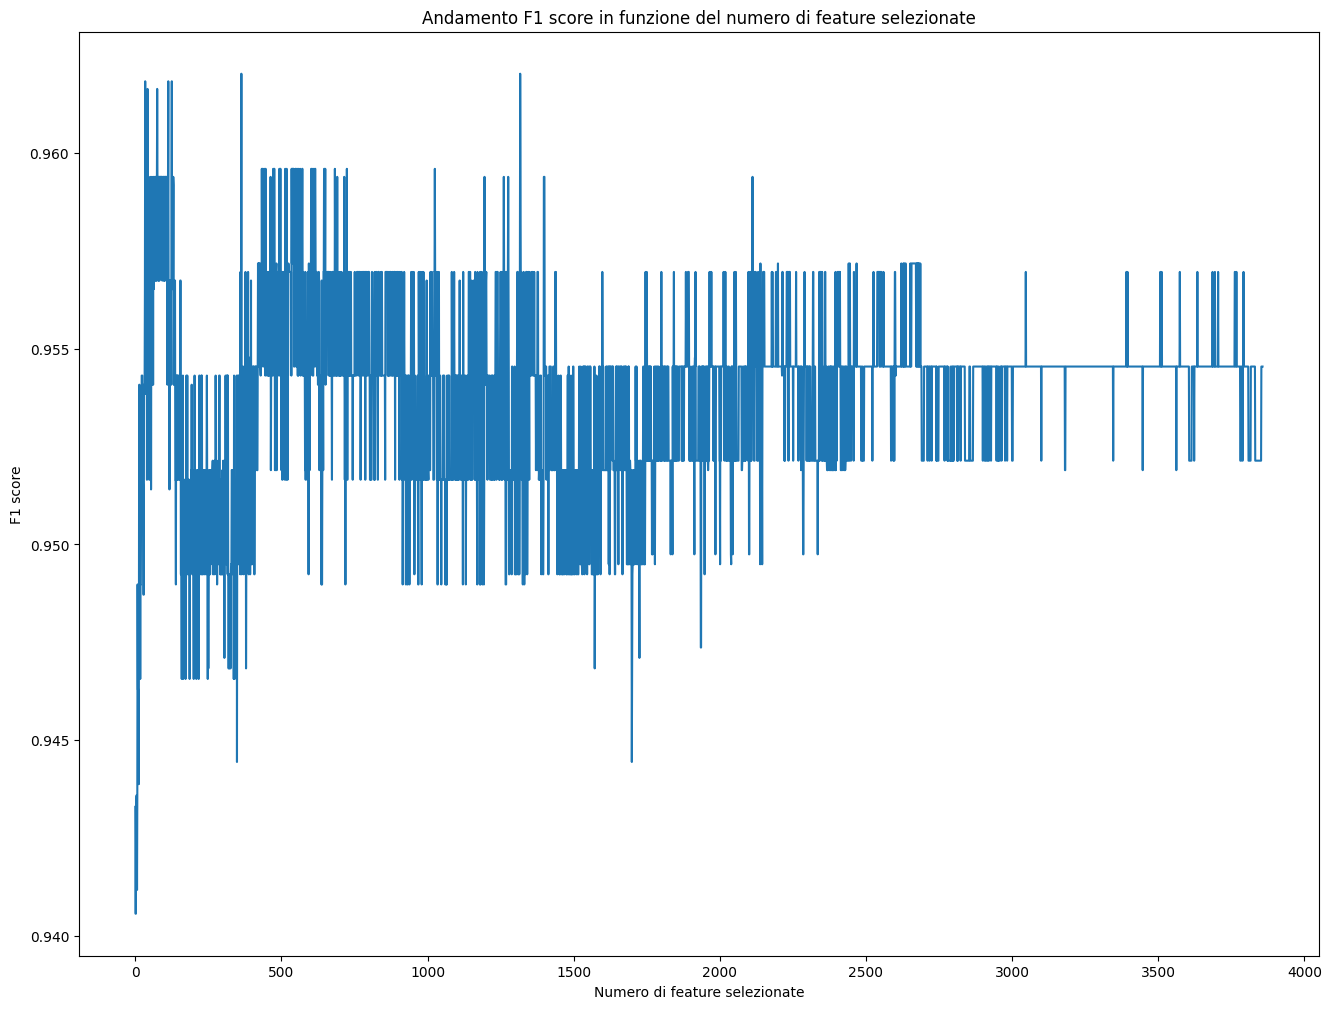

In [30]:
def prettyPrint(sortedFeature):
    print("Score\tnumFeature\tfeature")
    for i in list(sortedFeature.keys())[:50]:
        print(str(sortedFeature[i])+"\t"+str(len(list(i)))+"\t", i)


prettyPrint(ensemble_sortedFeature)

fig, ax = plt.subplots(figsize=(16, 12))

ax.plot(list(ensemble_featureSelected.values()))
ax.set_title("Andamento F1 score in funzione del numero di feature selezionate")
ax.set_xlabel("Numero di feature selezionate")
ax.set_ylabel("F1 score")
plt.show()

In [16]:
max = 0
for i in list(ensemble_sortedFeature.keys()):
    n = len(list(i))
    if n > max: max = n

print(max)

3862


Minor sottoinsieme di geni con F1 score su validation maggiore di 0.98

In [6]:
keys_with_value = [key for key, value in ensemble_featureSelected.items() if value > 0.962]
sorted_keys = sorted(keys_with_value, key=lambda x: len(x), reverse=False)
print(len(sorted_keys[0]))

368


Controllo quali delle migliori 100 feature per importance appartengono al sottoinsieme selezionato (spoiler tutte)

In [27]:
ensemble_featureSelected = dict(sorted(ensemble_featureSelected.items(), key=lambda x: x[1], reverse=True))

cont = 0
for feature in list(expl_sorted.keys())[:100]:
    if feature in sorted_keys[0]:
        cont+=1
        print(feature)
        
print(cont)

DDX3Y
USP9Y
GIT2
PABPC1
RPS4Y1
C4BPA
HLA-DRB5
HLA-DRB1
UBR4
CRIPTO
S100B
CXCL2
PFDN5
IL22
ZFY
KCNE2
BTNL3
EEF1A1
GABRB2
HNRNPA1
LALBA
AREG
RPL13A
RPS3
USP25
RPS29
TRMT5
SEMA4D
VDAC3
RPL28
NIPSNAP3B
FRG1
RPS28
APOO
GLRA2
EXOSC8
APOC1
CTNNBL1
RAB5IF
OR10J1
THAP9
RBPJL
VHL
STARD7
LRRC37A
RPS10
MLC1
PUS3
LYZL6
MCTS1
RPL31
KLHL29
SOX3
SIT1
NPM1
GAPDH
TPD52
SEC14L3
AMBN
PPP1R12B
PSMD6
ATP5MG
NEK7
ATOH1
EIF4EBP2
SNX19
OVOL1
PPIA
MAD2L1BP
ADSL
PRKD1
LONP2
SULT1A2
RXRB
RAPGEF3
RPS12
BGN
KLK3
PMCH
CLEC2B
PHB2
CTAGE1
LDB3
EXOSC1
NKX2-5
DDX5
SEC23A
TRMT2B
JPT1
RALGAPA1
AP1S1
RWDD1
SLC22A17
SRR
NDUFB8
RSL1D1
TRMU
ERGIC3
MT1X
AZU1
100


Cerco le feature importanti sia per ablation che per feature selection

In [28]:
print("Il sottoinsieme migliore di feature conta: ", len(sorted_keys[0]), "elementi, che sono: ", sorted_keys[0])

ensemble_ablation = dict(sorted(ensemble_ablation.items(), key=lambda x: x[1], reverse=True))
ensemble_ablationSubset = {key: value for key, value in ensemble_ablation.items() if key in sorted_keys[0]}
ensemble_ablationSubsetSorted = dict(sorted(ensemble_ablationSubset.items(), key=lambda x: x[1]))
print(ensemble_ablationSubsetSorted)

def resume(ablationSubsetSorted):
    result = {'-1':0, '0':0, '1':0}
    for key, value in ablationSubsetSorted.items():
        if value < 1:
            result['-1'] += 1
        elif value == 1.0:
            result['0'] += 1
        else:
            result['1'] += 1
    return result

print(resume(ensemble_ablationSubsetSorted))

ensemble_best = []
for key, value in ensemble_ablationSubsetSorted.items():
        if value > 1: 
            print(key, ":", value)
            ensemble_best.append(key)

print(ensemble_best)

Il sottoinsieme migliore di feature conta:  1889 elementi, che sono:  ('DDX3Y', 'USP9Y', 'GIT2', 'PABPC1', 'RPS4Y1', 'C4BPA', 'HLA-DRB5', 'HLA-DRB1', 'UBR4', 'CRIPTO', 'S100B', 'CXCL2', 'PFDN5', 'IL22', 'ZFY', 'KCNE2', 'BTNL3', 'EEF1A1', 'GABRB2', 'HNRNPA1', 'LALBA', 'AREG', 'RPL13A', 'RPS3', 'USP25', 'RPS29', 'TRMT5', 'SEMA4D', 'VDAC3', 'RPL28', 'NIPSNAP3B', 'FRG1', 'RPS28', 'APOO', 'GLRA2', 'EXOSC8', 'APOC1', 'CTNNBL1', 'RAB5IF', 'OR10J1', 'THAP9', 'RBPJL', 'VHL', 'STARD7', 'LRRC37A', 'RPS10', 'MLC1', 'PUS3', 'LYZL6', 'MCTS1', 'RPL31', 'KLHL29', 'SOX3', 'SIT1', 'NPM1', 'GAPDH', 'TPD52', 'SEC14L3', 'AMBN', 'PPP1R12B', 'PSMD6', 'ATP5MG', 'NEK7', 'ATOH1', 'EIF4EBP2', 'SNX19', 'OVOL1', 'PPIA', 'MAD2L1BP', 'ADSL', 'PRKD1', 'LONP2', 'SULT1A2', 'RXRB', 'RAPGEF3', 'RPS12', 'BGN', 'KLK3', 'PMCH', 'CLEC2B', 'PHB2', 'CTAGE1', 'LDB3', 'EXOSC1', 'NKX2-5', 'DDX5', 'SEC23A', 'TRMT2B', 'JPT1', 'RALGAPA1', 'AP1S1', 'RWDD1', 'SLC22A17', 'SRR', 'NDUFB8', 'RSL1D1', 'TRMU', 'ERGIC3', 'MT1X', 'AZU1', 'CCT

Calcolo SHAP values sul modello ridotto

In [ ]:
ensembleSelected = joblib.load('../../ShapValues/DatasetZeroes/ensembleSelected_39.pkl')